In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from datetime import datetime
import time


import cv2
import pydicom as dicom
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from pydicom import dcmread
from skimage import data, color



In [2]:
import os
os.chdir('/Volumes/Raj_2TB/Melanoma')

df = pd.read_csv('train.csv')
df.head()



,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [3]:
df.shape


(33126, 8)

In [4]:
import random
seed=5
s0 = df.target[df.target.eq(0)].sample(50,random_state=seed).index
s1 = df.target[df.target.eq(1)].sample(50,random_state=seed).index
#print(s0)
#print(s1)
df= df.loc[s0.union(s1)]
df['target'].value_counts()

1    50
0    50
Name: target, dtype: int64

In [5]:
print(df.patient_id.nunique())
print(df.patient_id.value_counts().head())
print(df.patient_id.value_counts().tail())

94
IP_7373371    3
IP_2412574    2
IP_3055814    2
IP_2986217    2
IP_8136122    2
Name: patient_id, dtype: int64
IP_7688774    1
IP_6936664    1
IP_4169963    1
IP_0881790    1
IP_8738175    1
Name: patient_id, dtype: int64


In [6]:
# Import the otsu threshold function
from skimage.filters import threshold_otsu

# Import Gaussian filter
from skimage.filters import gaussian


#read image file
def dicom_to_array(filename):
    d = dicom.read_file(filename)
    a = d.pixel_array
    return a,d


#Display one image
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

#Display two images    
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True,
    sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

    
#Image scaling   
def imgResize(a1):
    width= a1.shape[1]
    height = a1.shape[0]
    ratio = width / height
    new_height = 32

    #new_width = int(ratio * new_height)

    #new_width = int(ratio * new_height)
    new_width=32
    dim=(new_width,new_height)

    #resized_img = resize(a1, dim, anti_aliasing=True)
    resized_img = cv2.resize(a1, dim, interpolation = cv2.INTER_AREA)

    return resized_img

#Gray scale image
def imgGray(a1):
    grayscale=color.rgb2gray(a1)  
    return grayscale

#Thresholding
def thresh_otsu(a1):
    # Obtain the optimal threshold value
    thresh = threshold_otsu(a1)
    # Apply thresholding to the image
    binary_global = (a1 > thresh)
    return binary_global

# Removing noise with gaussian filter
def smoothing(a1):
    # Apply filter
    gaussian_image = gaussian(a1, multichannel=True)
    
    return gaussian_image
    # Show original and resulting image to compare
    #plot_comparison(original, gaussian_image, "Blurred with Gaussian filter")
    #show_image(original, "Original")
    #show_image(gaussian_image, "Reduced sharpness Gaussian")


calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Dicom images rescaled same height (32 pixels) but different width.
 
0 train/ISIC_0167093.dcm Original Dimensions :  (480, 640, 3) Resized Dimensions (32, 32, 3)
1 train/ISIC_0647224.dcm Original Dimensions :  (480, 640, 3) Resized Dimensions (32, 32, 3)
2 train/ISIC_0906053.dcm Original Dimensions :  (2448, 3264, 3) Resized Dimensions (32, 32, 3)
3 train/ISIC_0953317.dcm Original Dimensions :  (1936, 2592, 3) Resized Dimensions (32, 32, 3)
4 train/ISIC_1037315.dcm Original Dimensions :  (2448, 3264, 3) Resized Dimensions (32, 32, 3)
5 train/ISIC_1132496.dcm Original Dimensions :  (1936, 2592, 3) Resized Dimensions (32, 32, 3)
6 train/ISIC_1157032.dcm Original Dimensions :  (2848, 4288, 3) Resized Dimensions (32, 32, 3)
7 train/ISIC_1799525.dcm Original Dimensions :  (1053, 1872, 3) Resized Dimensions (32, 32, 3)
8 train/ISIC_2012245.dcm Original Dimensions :  (480, 640, 3) Resized Dimensions (32, 32, 3)
9 train/ISIC_2048638.dcm Original Dimensions :  (480, 640, 3) Resized Dimensions (

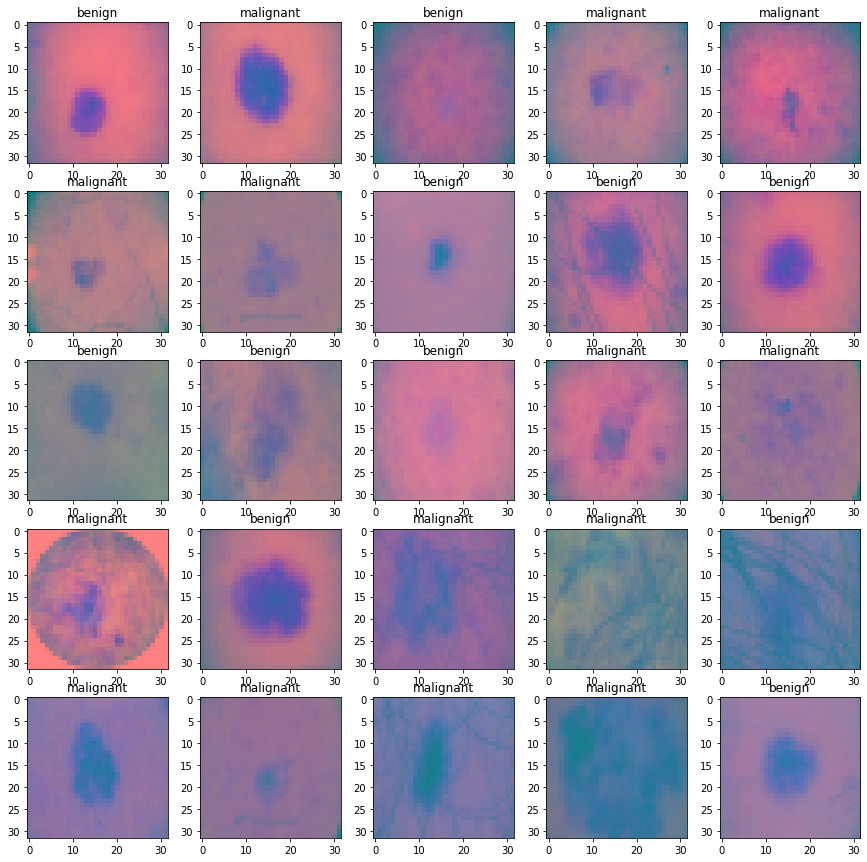

In [7]:
print("Dicom images rescaled same height (32 pixels) but different width.")
#print("Dicom images rescaled to 32 by 32 pixels")
print(" ")
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image ='train/'+df['image_name'].iloc[i] +'.dcm'
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
        
        
    resized_img=imgResize(a1)
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    plt.imshow(resized_img)
    print(i,image,'Original Dimensions : ',a1.shape,"Resized Dimensions",resized_img.shape)


    

Images with noise removal


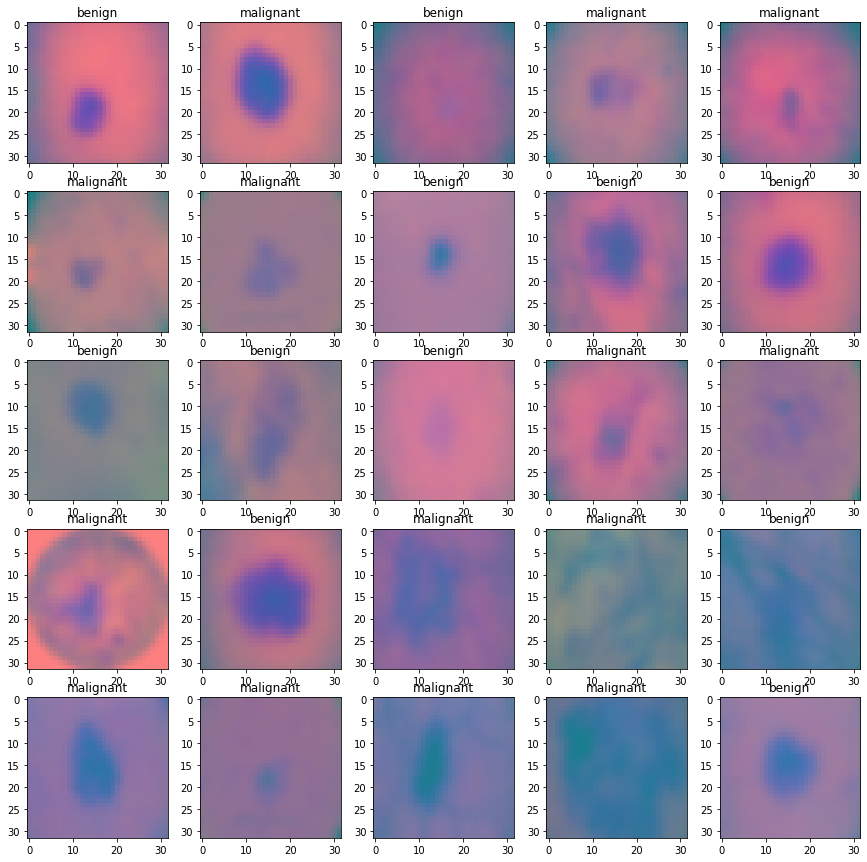

In [8]:
print("Images with noise removal")
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image ='train/'+df['image_name'].iloc[i] +'.dcm'
    
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
    
    #image resize
    resized_img=imgResize(a1)
    
    # Removing noise with gaussian filter
    gaussian_image=smoothing(resized_img)
    
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    #plt.imshow(resized_img)
    plt.imshow(gaussian_image)
    

Gray scaled images


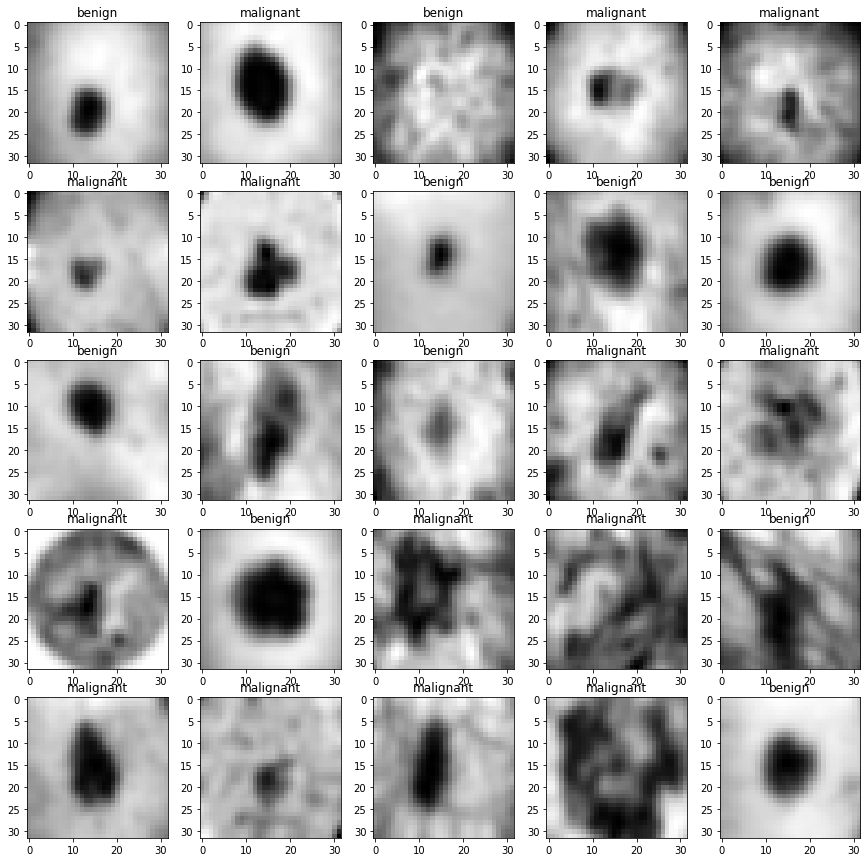

In [9]:
print("Gray scaled images")
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image ='train/'+df['image_name'].iloc[i] +'.dcm'
    
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
    
    #Image rescaling
    resized_img=imgResize(a1)
    
    # Removing noise with gaussian filter
    gaussian_image=smoothing(resized_img)
    
    #Gray scale image
    grayscale=imgGray(gaussian_image)
    
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    #plt.imshow(resized_img)
    plt.imshow(grayscale,cmap="gray")
    

Thresholded images with otsu
 


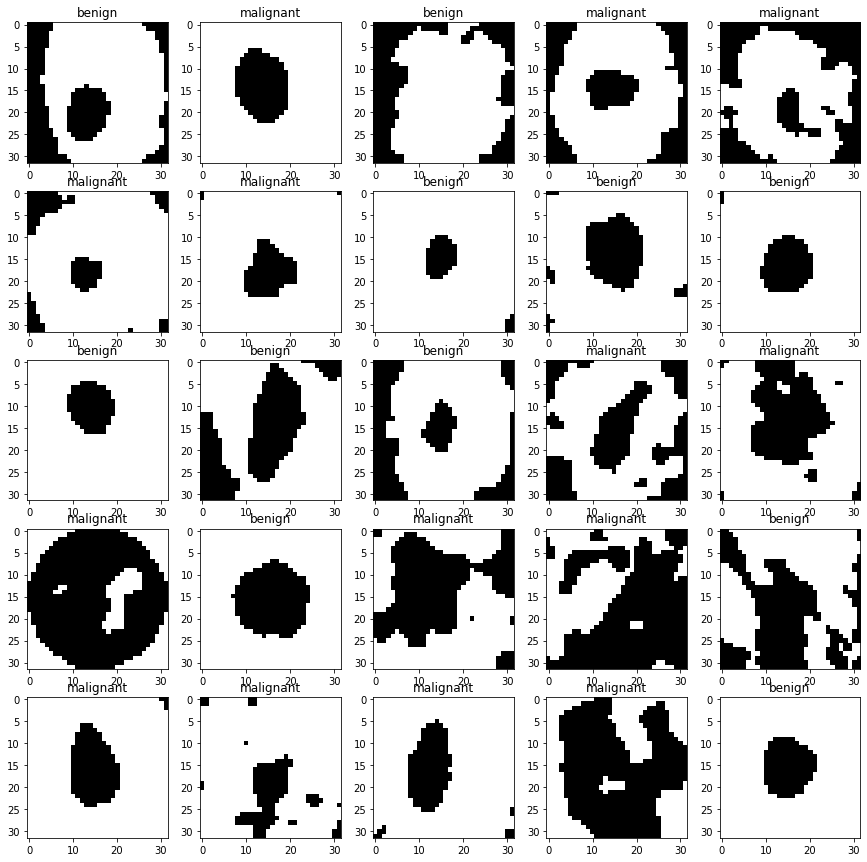

In [10]:
print("Thresholded images with otsu")
print(" ")
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image ='train/'+df['image_name'].iloc[i] +'.dcm'
    
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
     
    #Image rescaling
    resized_img=imgResize(a1)
    
    # Removing noise with gaussian filter
    gaussian_image=smoothing(resized_img)
    
    #Gray scale image
    grayscale=imgGray(gaussian_image)
    
    # Obtain threshold image with  otsu
    binary_global=thresh_otsu(grayscale)
    
    
    
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    #plt.imshow(resized_img)
    plt.imshow(binary_global,cmap="gray")
    #show_image(binary_global, 'Global thresholding')
    

Morphological filtering with erosion on thresholded images


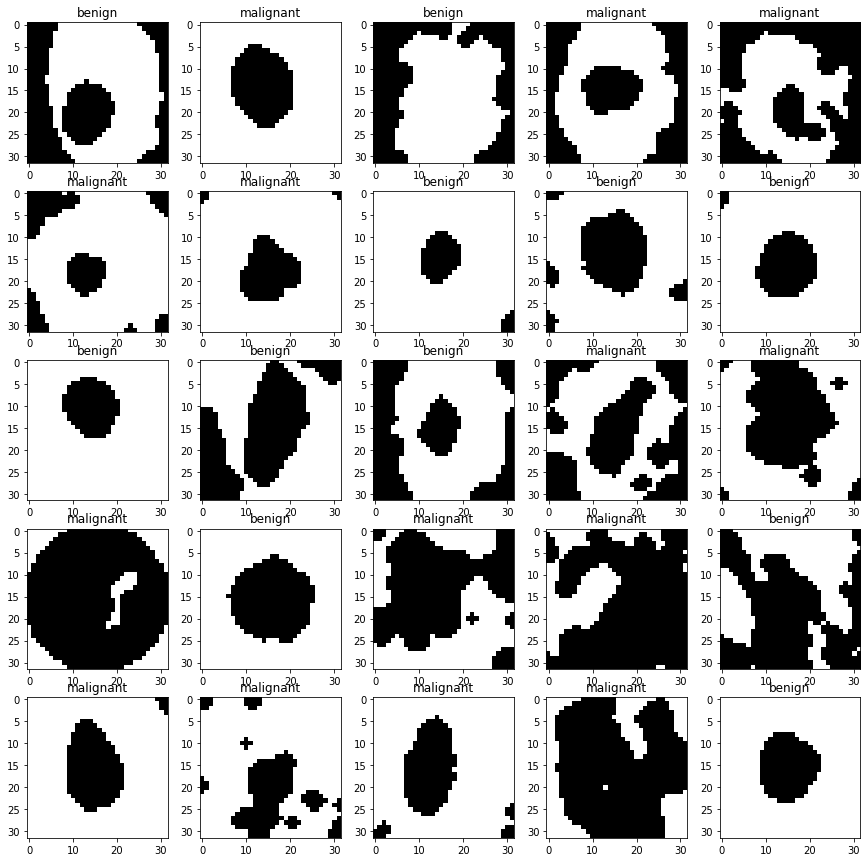

In [11]:
print("Morphological filtering with erosion on thresholded images")

from skimage import morphology

fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image ='train/'+df['image_name'].iloc[i] +'.dcm'
    
    a1,d = dicom_to_array(image)
    # create subplot and append to ax
     
    #Image rescaling
    resized_img=imgResize(a1)
    
    # Removing noise with gaussian filter
    gaussian_image=smoothing(resized_img)
    
    #Gray scale image
    grayscale=imgGray(gaussian_image)
    
    # Obtain threshold image with  otsu
    binary_global=thresh_otsu(grayscale)
    

    # Obtain eroded image, using binary erosion
    eroded_image = morphology.binary_erosion(binary_global)
    
    
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    
    
    #plt.imshow(resized_img)
    #plt.imshow(dilated_image,cmap="gray")
    plt.imshow(eroded_image,cmap="gray")
    #show_image(binary_global, 'Global thresholding')



Morphological filtering with erosion followed by dilation on thresholded images


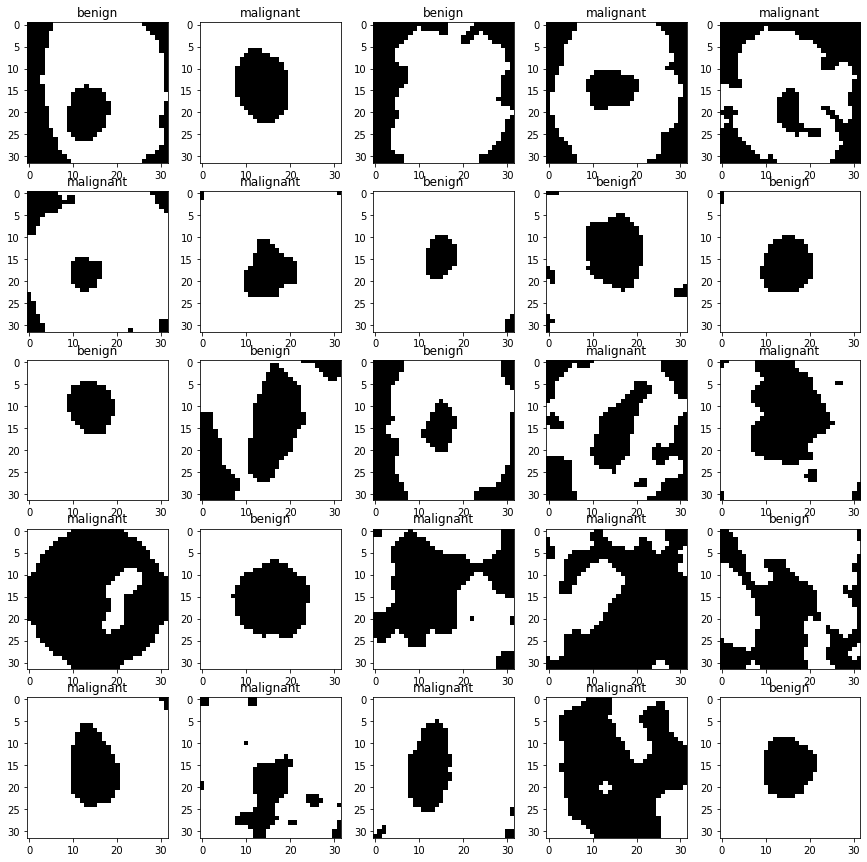

In [12]:
print("Morphological filtering with erosion followed by dilation on thresholded images")

from skimage import morphology

fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    image ='train/'+df['image_name'].iloc[i] +'.dcm'
    
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
     
    resized_img=imgResize(a1)
    
    #Image rescaling
    resized_img=imgResize(a1)
    
    # Removing noise with gaussian filter
    gaussian_image=smoothing(resized_img)
    
    #Gray scale image
    grayscale=imgGray(gaussian_image)
    
    # Obtain threshold image with  otsu
    binary_global=thresh_otsu(grayscale)

    # Obtain dilated image, using binary dilation
    eroded_image = morphology.binary_erosion(binary_global)
 

    # Obtain dilated image, using binary dilation
    dilated_image = morphology.binary_dilation(eroded_image)

    
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    
    
    #plt.imshow(resized_img)
    plt.imshow(dilated_image,cmap="gray")
    
    #show_image(binary_global, 'Global thresholding')



